In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
# knot = 'standard_16'
# filename = f'..\data\data_{knot}.csv'
# with open(filename, 'r') as file:
#     reader = csv.reader(file)
#     for row in reader:
#         # Deserialize the JSON string back to a list
#         data_list = json.loads(row[0])
#         # Convert the list back to a NumPy array if needed
#         data_array = np.array(data_list)
#         print(data_array.shape)

In [47]:
# Nx, Ny, Nz = data_array[1]
# number = data_array[0][0]
# points_list = data_array[2:]
#
# # Initialize a 3D array with zeros
# dots_3d = np.zeros((Nx, Ny, Nz), dtype=int)
#
# # Set the specified coordinates to 1
# for x, y, z in points_list:
#     dots_3d[x, y, z] = 1

In [63]:
knot_types = {
	'standard_14': 0,  # 1
	'standard_16': 1,  # 2
	'standard_18': 2,  # 3
	'30both': 3,  # 4
	'30oneZ': 4,  # 5
	'optimized': 5,  # 6
	'pm_03_z': 6,  # 7
	'4foil': 7,  # 8
	'6foil': 8,  # 9
	'stand4foil': 9,  # 10
	'30oneX': 10,  # 11

}
knots = [
	'standard_14', 'standard_16', 'standard_18', '30both', '30oneZ',
	'optimized', 'pm_03_z', '4foil', '6foil', 'stand4foil',
	'30oneX'
]

desired_res = (16, 16, 16)

num_classes = len(knots)
X_list = []
Y_list = []
for knot in knots:
    filename = f'..\data\data_{knot}.csv'
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            # Deserialize the JSON string back to a list
            data_list = json.loads(row[0])
            # Convert the list back to a NumPy array if needed
            data_array = np.array(data_list)
            points_list = data_array[2:]
            Nx, Ny, Nz = data_array[1]
            if desired_res != (Nx, Ny, Nz):
                scale_x = desired_res[0] / Nx
                scale_y = desired_res[1] / Ny
                scale_z = desired_res[2] / Nz
                points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
            # Initialize a 3D array with zeros
            dots_3d = np.zeros(desired_res, dtype=int)
            # Set the specified coordinates to 1
            for x, y, z in points_list:
                try: dots_3d[x, y, z] = 1
                except IndexError: continue
            X_list.append(dots_3d)
            # X_list.append(data_array)
            Y_list.append(knot_types[knot])


In [49]:
# print(Y_list)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [50]:
# class CustomDataset(torch.utils.data.Dataset):
#     def __init__(self, X_list, y_list, desired_res):
#
#         # self.dataset = dataset
#         self.X = X_list
#         self.y = y_list
#         self.desired_res = desired_res
#
#     def __len__(self):
#
#         return len(self.X)
#
#     def __getitem__(self, idx):
#         """
#         Retrieves the sample and its label at the given index.
#
#         Args:
#             idx: Index of the sample to retrieve.
#
#         Returns:
#             A tuple (sample, label).
#         """
#         Nx, Ny, Nz = self.X[idx][1]
#         # number = data_array[0][0]
#         points_list = self.X[idx][2:]
#         # print(points_list)
#         dots_3d = np.zeros(self.desired_res, dtype=int)
#         if self.desired_res != (Nx, Ny, Nz):
#             scale_x = self.desired_res[0] / Nx
#             scale_y = self.desired_res[1] / Ny
#             scale_z = self.desired_res[2] / Nz
#             points_list = np.rint(points_list * np.array([scale_x, scale_y, scale_z])).astype(int)
#         # Initialize a 3D array with zeros
#         # # Set the specified coordinates to 1
#         for x, y, z in points_list:
#             try: dots_3d[x, y, z] = 1
#             except IndexError: continue
#
#         # X_list.append(dots_3d)
#         data = torch.tensor(dots_3d).reshape(1, *self.desired_res).float()
#         label = torch.tensor(self.y[idx])
#         # Here, you can add custom processing to your data
#         # For example, adding a custom transformation, processing data, etc.
#
#         return data, label
#
#     def getitem_slice(self, idx):
#         """
#         Retrieves the sample and its label at the given index.
#
#         Args:
#             idx: Index of the sample to retrieve.
#
#         Returns:
#             A tuple (sample, label).
#         """
#         Nx_ar, Ny_ar, Nz_ar = np.array([self.X[i][1] for i in range(idx.start, idx.stop)]).T
#         # number = data_array[0][0]
#         points_list = [self.X[i][2:] for i in range(idx.start, idx.stop)]
#         # print(points_list)
#         dots_3d = np.zeros(((idx.stop-idx.start), *self.desired_res), dtype=int)
#         for i in range(len(Nx_ar)):
#             if self.desired_res != (Nx_ar[i], Ny_ar[i], Nz_ar[i]):
#                 scale_x = self.desired_res[0] / Nx_ar[i]
#                 scale_y = self.desired_res[1] / Ny_ar[i]
#                 scale_z = self.desired_res[2] / Nz_ar[i]
#                 points_list[i] = np.rint(points_list[i] * np.array([scale_x, scale_y, scale_z])).astype(int)
#             # Initialize a 3D array with zeros
#             # # Set the specified coordinates to 1
#             for x, y, z in points_list[i]:
#                 try: dots_3d[i, x, y, z] = 1
#                 except IndexError: continue
#
#         # X_list.append(dots_3d)
#         data = torch.tensor(dots_3d).reshape(-1, 1, *self.desired_res).float()
#         label = torch.tensor(self.y[idx]).float()
#         # Here, you can add custom processing to your data
#         # For example, adding a custom transformation, processing data, etc.
#
#         return data, label


In [51]:
# desired_res = (32, 32, 32)
# XY_dataset = CustomDataset(X_list, Y_list, desired_res=desired_res)
# XY_dataset[1][0].shape

In [52]:
# # Define the proportions
# train_ratio = 0.6
# val_ratio = 0.2
# test_ratio = 0.2
# total_length = len(XY_dataset)
# train_length = int(total_length * train_ratio)
# val_length = int(total_length * val_ratio)
# test_length = total_length - train_length - val_length
#
# train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(XY_dataset, [train_length, val_length, test_length])
#
# print(f"Training Set: {len(train_dataset)} samples")
# print(f"Validation Set: {len(val_dataset)} samples")
# print(f"Test Set: {len(test_dataset)} samples")

In [64]:
X_np = np.array(X_list)
y_np = np.array(Y_list)
X_torch = torch.tensor(X_np).reshape(-1,1, *desired_res).float()
# X_torch = torch.tensor(X_np).float()
y_torch_list = torch.tensor(y_np)
y_torch = F.one_hot(y_torch_list.long(), num_classes=num_classes).float()
print(X_torch.shape, y_torch.shape)

torch.Size([13200, 1, 16, 16, 16]) torch.Size([13200, 11])


In [65]:
X_train, X_val_test, y_train, y_val_test = train_test_split(X_torch, y_torch, test_size=0.3, random_state=37)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=37)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

In [55]:
# dots_bound = [
#     [0, 0, 0],
#     [Nx, Ny, Nz],
# ]
# # pl.plotDots(dots_init, dots_init, color='black', show=True, size=10)
# pl.plotDots(points_list, dots_bound, color='black', show=False, size=10)

In [56]:
def conv_stage(layer_configs):
    layers = []
    for config in layer_configs:
        in_channels, out_channels, kernel_size, stride, padding = config
        layers.append(nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding))
        layers.append(nn.BatchNorm3d(out_channels))
        layers.append(nn.ReLU(inplace=True))

    return nn.Sequential(*layers)

def create_pooling_layer(config):
    if config is None:
        return None
    kernel_size, stride, padding = config
    return nn.MaxPool3d(kernel_size=kernel_size, stride=stride, padding=padding)

class Classifier3D(nn.Module):
    def __init__(self, stages, pooling_configs, num_classes=11, desired=desired_res):
        super(Classifier3D, self).__init__()

        self.features = nn.Sequential()
        self.desired = desired_res

        for i, stage in enumerate(stages):
            # Add the convolutional stage
            self.features.add_module(f"stage_{i}", conv_stage(stage))

            # Add a custom MaxPooling layer after each stage based on the pooling configuration
            if i < len(pooling_configs):
                pool_layer = create_pooling_layer(pooling_configs[i])
                if pool_layer:
                    self.features.add_module(f"pool_{i}", pool_layer)


        # Calculate the size of the flattened features after the conv layers
        self._to_linear = None
        self._get_conv_output((1, *self.desired))

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 256)
        # self.fc2 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(256, num_classes)

    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self.features(input)
        self._to_linear = int(np.prod(output_feat.size()[1:]))

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm3d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # Flatten the output
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = self.fc2(x)
        x = nn.Softmax(1)(x)
        return x


In [57]:
# in_channels, out_channels, kernel_size, stride, padding
stages = [
    [(1, 16, 3, 1, 1), (16, 16, 3, 1, 1)],
    # [(32, 64, 3, 1, 1), (64, 64, 3, 1, 1)],
    [(16, 32, 5, 1, 1)],  [(32, 32, 5, 1, 1)]
]

# Define pooling configurations: (kernel_size, stride, padding)
# Set to 'None' for stages where no pooling is desired
# kernel_size, stride, padding
pooling_configs = [
    (2, 2, 1),  # Pooling after the first stage
    # (3, 2, 1),  # Pooling after the second stage
    (2, 2, 1)      # No pooling after the third stage
]

model = Classifier3D(stages, pooling_configs, num_classes=11).to(device)
model.initialize_weights()

In [58]:
# print(model._to_linear, 512 * 16 * 16)
dots_3d_toch_batch = train_dataset[1:2][0].to(device)
print(dots_3d_toch_batch.shape)
model(dots_3d_toch_batch)

torch.Size([1, 1, 16, 16, 16])


tensor([[0.0908, 0.0915, 0.0925, 0.0907, 0.0908, 0.0947, 0.0893, 0.0897, 0.0887,
         0.0902, 0.0909]], grad_fn=<SoftmaxBackward0>)

In [76]:
def loop_train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    for i, (inputs, targets) in enumerate(train_loader, 1):  # Start enumeration from 1
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        total_loss += loss.item()  # Accumulate the loss

    return total_loss / len(train_loader)  # Return the average loss


def loop_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss
            total_loss += loss.item()  # Accumulate the loss
    return total_loss / len(test_loader)  # Return the average loss


def correct_number_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            correct = criterion(outputs, targets)  # Compute correct
            total_correct += correct  # Accumulate correct
            total += len(outputs)  # Accumulate total
    return total_correct, total  # Return the average loss


def plot_losses(train_losses, test_losses, decimals=3):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses,
             label=f'Train Loss {train_losses[-1]: .{decimals}f} (min: {min(train_losses): .{decimals}f})')
    plt.plot(test_losses, label=f'Test Loss {test_losses[-1]: .{decimals}f} (min: {min(test_losses): .{decimals}f})')
    plt.title('Training and Testing Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [60]:
hyperparams = {
    'learning_rate': 1e-4,  # Control dropout rate
    'patience': 15,  # Number of epochs between learning rate decay
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 3
}
# criterion = nn.MSELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=hyperparams['factor'], patience=hyperparams['patience'],
                              verbose=True)

num_epochs = 50
print_every = 1

train_losses = []
val_losses = []
train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=hyperparams['batch_size'])
for epoch in trange(num_epochs, desc="Progress"):
    train_losses.append(loop_train(model, train_loader, criterion, optimizer))
    val_losses.append(loop_test(model, val_loader, criterion))

    scheduler.step(val_losses[-1])

    if (epoch + 1) % print_every == 0:
        print(f'Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

    # # Save model and losses every 50 epochs
    # if (epoch + 1) % 100 == 0:
    #     # Save the model state
    #     print(f'model_epoch_{epoch + 1}.pth was saved')
    #     name = (
    #         f'batch={params["batch_size"]}_lr={hyperparams["learning_rate"]}_drop={hyperparams["dropout_rate"]}'
    #         f'_{name_extra}_'
    #     )
    #     torch.save(model.state_dict(), f'model_epoch_{epoch + 1}_{name}.pth')
    #     # Save losses
    #     with open(f'losses_epoch_{epoch + 1}_{name}.txt', 'w') as f:
    #         f.write(f'Train Losses: {train_losses}\n')
    #         f.write(f'Validation Losses: {val_losses}\n')


Progress:   2%|▏         | 1/50 [00:28<23:32, 28.82s/it]

Epoch 0: Train Loss: 1.7406, Val Loss: 1.5767


Progress:   4%|▍         | 2/50 [00:57<23:09, 28.94s/it]

Epoch 1: Train Loss: 1.5697, Val Loss: 1.5709


Progress:   6%|▌         | 3/50 [01:26<22:38, 28.90s/it]

Epoch 2: Train Loss: 1.5601, Val Loss: 1.5626


Progress:   8%|▊         | 4/50 [01:55<22:11, 28.94s/it]

Epoch 3: Train Loss: 1.5567, Val Loss: 1.5669


Progress:  10%|█         | 5/50 [02:24<21:40, 28.91s/it]

Epoch 4: Train Loss: 1.5546, Val Loss: 1.5586


Progress:  12%|█▏        | 6/50 [02:53<21:12, 28.92s/it]

Epoch 5: Train Loss: 1.5531, Val Loss: 1.5580


Progress:  14%|█▍        | 7/50 [03:22<20:43, 28.92s/it]

Epoch 6: Train Loss: 1.5502, Val Loss: 1.5584


Progress:  16%|█▌        | 8/50 [03:51<20:15, 28.93s/it]

Epoch 7: Train Loss: 1.5510, Val Loss: 1.5585


Progress:  18%|█▊        | 9/50 [04:20<19:48, 28.98s/it]

Epoch 8: Train Loss: 1.5494, Val Loss: 1.5585


Progress:  20%|██        | 10/50 [04:49<19:19, 28.98s/it]

Epoch 9: Train Loss: 1.5498, Val Loss: 1.5570


Progress:  22%|██▏       | 11/50 [05:18<18:48, 28.95s/it]

Epoch 10: Train Loss: 1.5489, Val Loss: 1.5642


Progress:  24%|██▍       | 12/50 [05:47<18:18, 28.90s/it]

Epoch 11: Train Loss: 1.5482, Val Loss: 1.5589


Progress:  26%|██▌       | 13/50 [06:16<17:50, 28.92s/it]

Epoch 12: Train Loss: 1.5481, Val Loss: 1.5681


Progress:  28%|██▊       | 14/50 [06:45<17:21, 28.94s/it]

Epoch 13: Train Loss: 1.5475, Val Loss: 1.5592


Progress:  30%|███       | 15/50 [07:13<16:51, 28.91s/it]

Epoch 14: Train Loss: 1.5466, Val Loss: 1.5615


Progress:  32%|███▏      | 16/50 [07:42<16:22, 28.90s/it]

Epoch 15: Train Loss: 1.5470, Val Loss: 1.5565


Progress:  34%|███▍      | 17/50 [08:11<15:53, 28.89s/it]

Epoch 16: Train Loss: 1.5462, Val Loss: 1.5587


Progress:  36%|███▌      | 18/50 [08:40<15:26, 28.95s/it]

Epoch 17: Train Loss: 1.5460, Val Loss: 1.5596


Progress:  38%|███▊      | 19/50 [09:09<14:57, 28.95s/it]

Epoch 18: Train Loss: 1.5471, Val Loss: 1.5574


Progress:  40%|████      | 20/50 [09:38<14:28, 28.93s/it]

Epoch 19: Train Loss: 1.5465, Val Loss: 1.5565


Progress:  42%|████▏     | 21/50 [10:07<14:01, 29.01s/it]

Epoch 20: Train Loss: 1.5456, Val Loss: 1.5575


Progress:  44%|████▍     | 22/50 [10:36<13:31, 28.97s/it]

Epoch 21: Train Loss: 1.5448, Val Loss: 1.5584


Progress:  46%|████▌     | 23/50 [11:05<13:01, 28.94s/it]

Epoch 22: Train Loss: 1.5464, Val Loss: 1.5573


Progress:  48%|████▊     | 24/50 [11:34<12:31, 28.91s/it]

Epoch 23: Train Loss: 1.5476, Val Loss: 1.5636


Progress:  50%|█████     | 25/50 [12:03<12:03, 28.95s/it]

Epoch 24: Train Loss: 1.5466, Val Loss: 1.5609


Progress:  52%|█████▏    | 26/50 [12:32<11:34, 28.96s/it]

Epoch 25: Train Loss: 1.5451, Val Loss: 1.5542


Progress:  54%|█████▍    | 27/50 [13:01<11:06, 28.97s/it]

Epoch 26: Train Loss: 1.5454, Val Loss: 1.5586


Progress:  56%|█████▌    | 28/50 [13:30<10:36, 28.95s/it]

Epoch 27: Train Loss: 1.5458, Val Loss: 1.5569


Progress:  58%|█████▊    | 29/50 [13:59<10:08, 28.99s/it]

Epoch 28: Train Loss: 1.5452, Val Loss: 1.5560


Progress:  60%|██████    | 30/50 [14:28<09:39, 29.00s/it]

Epoch 29: Train Loss: 1.5449, Val Loss: 1.5571


Progress:  62%|██████▏   | 31/50 [14:57<09:10, 28.97s/it]

Epoch 30: Train Loss: 1.5445, Val Loss: 1.5643


Progress:  64%|██████▍   | 32/50 [15:26<08:41, 28.99s/it]

Epoch 31: Train Loss: 1.5467, Val Loss: 1.5566


Progress:  66%|██████▌   | 33/50 [15:55<08:12, 28.97s/it]

Epoch 32: Train Loss: 1.5448, Val Loss: 1.5569


Progress:  68%|██████▊   | 34/50 [16:24<07:43, 28.99s/it]

Epoch 33: Train Loss: 1.5441, Val Loss: 1.5569


Progress:  70%|███████   | 35/50 [16:53<07:14, 28.96s/it]

Epoch 34: Train Loss: 1.5471, Val Loss: 1.5597


Progress:  72%|███████▏  | 36/50 [17:22<06:45, 28.99s/it]

Epoch 35: Train Loss: 1.5447, Val Loss: 1.5574


Progress:  74%|███████▍  | 37/50 [17:51<06:17, 29.02s/it]

Epoch 36: Train Loss: 1.5456, Val Loss: 1.5583


Progress:  76%|███████▌  | 38/50 [18:20<05:48, 29.05s/it]

Epoch 37: Train Loss: 1.5448, Val Loss: 1.5559


Progress:  78%|███████▊  | 39/50 [18:49<05:18, 28.99s/it]

Epoch 38: Train Loss: 1.5440, Val Loss: 1.5580


Progress:  80%|████████  | 40/50 [19:18<04:50, 29.05s/it]

Epoch 39: Train Loss: 1.5449, Val Loss: 1.5568


Progress:  82%|████████▏ | 41/50 [19:47<04:21, 29.05s/it]

Epoch 40: Train Loss: 1.5455, Val Loss: 1.5557


Progress:  84%|████████▍ | 42/50 [20:16<03:52, 29.00s/it]

Epoch 00042: reducing learning rate of group 0 to 2.0000e-05.
Epoch 41: Train Loss: 1.5452, Val Loss: 1.5554


Progress:  86%|████████▌ | 43/50 [20:45<03:23, 29.00s/it]

Epoch 42: Train Loss: 1.5439, Val Loss: 1.5547


Progress:  88%|████████▊ | 44/50 [21:14<02:54, 29.04s/it]

Epoch 43: Train Loss: 1.5437, Val Loss: 1.5542


Progress:  88%|████████▊ | 44/50 [21:41<02:57, 29.57s/it]


KeyboardInterrupt: 

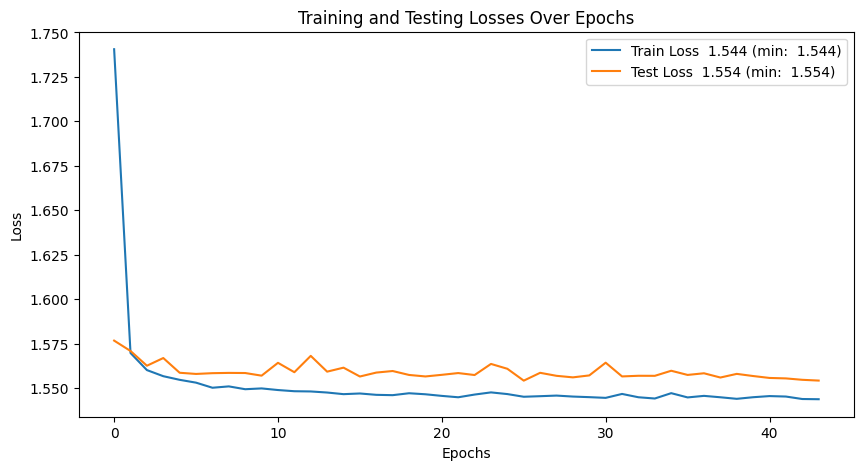

In [68]:
plot_losses(train_losses, val_losses, decimals=3)

In [ ]:
for epoch in trange(num_epochs, desc="Progress"):
    train_losses.append(loop_train(model, train_loader, criterion, optimizer))
    val_losses.append(loop_test(model, val_loader, criterion))

    scheduler.step(val_losses[-1])

    if (epoch + 1) % print_every == 0:
        print(f'Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

In [66]:
predictions = model(X_torch.to(device))
# predictions

In [78]:
def criterion_correct(predictions, labels):
    _, predicted_labels = torch.max(predictions, 1)
    _, true_class_labels = torch.max(labels, 1)
    # print(predicted_labels)
    # print(y_torch)
    correct_predictions = torch.sum(predicted_labels == true_class_labels).item()
    return correct_predictions


correct_predictions, total = correct_number_test(model, test_loader, criterion_correct)
print(f"Number of correct predictions (test): {correct_predictions}/{total}")

correct_predictions, total = correct_number_test(model, val_loader, criterion_correct)
print(f"Number of correct predictions (val): {correct_predictions}/{total}")

Number of correct predictions (test): 1545/1568
Number of correct predictions (val): 1549/1567
